# Compare the performance of several pre-processing pipelines in terms of motion correction as measured by the root mean square of the temporal derivative of the post-processed fMRI signal (DVARS)

### DVARS - check https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0173289 and https://www.sciencedirect.com/science/article/pii/S1053811917310972

In [1]:
import glob
import os
import sys

import pandas as pd
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns

from scipy import stats
from scipy.stats import wilcoxon

from statsmodels.stats.multitest import multipletests
import statannot
from statannot import add_stat_annotation

import xlrd
import itertools

In [ ]:
# First, check if the ASC and TD groups differ significantly in terms of age, IQ 
# and in-scanner movement (i.e. framewise displacement - FD)
# Participant list : 
# M005B, M007A, M008A, M010A, M013B, M014A, M015C, M016C, M020B
# M105B, M106C, M109C, M110A, M111B, M114A, M115C, M121A

In [3]:
# Load FD data
fd_data = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/mean_fd_split.xlsx', sheet_name='asc_td_p', engine='openpyxl')

In [4]:
# Split into groups
fd_data_td = fd_data.iloc[:9,1]
print(fd_data_td)
fd_data_asc = fd_data.iloc[11:19,1] # get only non-NaN values as the NaN values are not actually missing values, rather the ASC sample size is just smaller
print(fd_data_asc)

0    0.060405
1    0.115580
2    0.062291
3    0.170476
4    0.067968
5    0.078633
6    0.085417
7    0.140576
8    0.264926
Name: fd, dtype: float64
11    0.128344
12    0.092802
13    0.153768
14    0.076472
15    0.565535
16    0.231221
17    0.057706
18    0.340496
Name: fd, dtype: float64


In [5]:
# To check for normality of data
def check_norm(data):
    # Visualise first
    plt.hist(data
             ,bins = 10
            )
    plt.show()
    
    k2, p = stats.normaltest(data)
    alpha = 0.05

    print('P-value = ' + '{0:.10f}'.format(p))

    # null hypothesis: x comes from a normal distribution
    if p < alpha:
        print("The null hypothesis can be rejected. The sample is NOT normally distributed.")
        return False
    else:
        print("The null hypothesis cannot be rejected. The sample is normally distributed.")
        return True

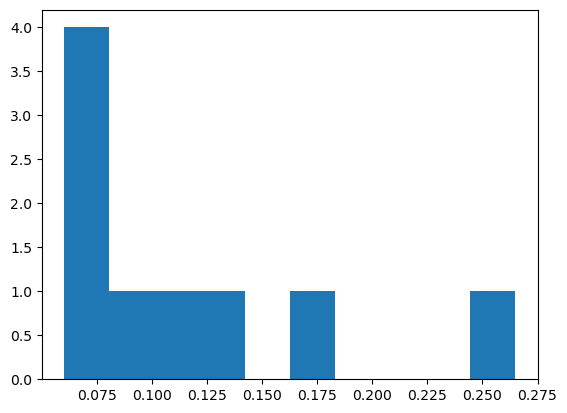

P-value = 0.0355545348
The null hypothesis can be rejected. The sample is NOT normally distributed.


In [13]:
# Check normality of the TD group
norm_td = check_norm(fd_data_td)

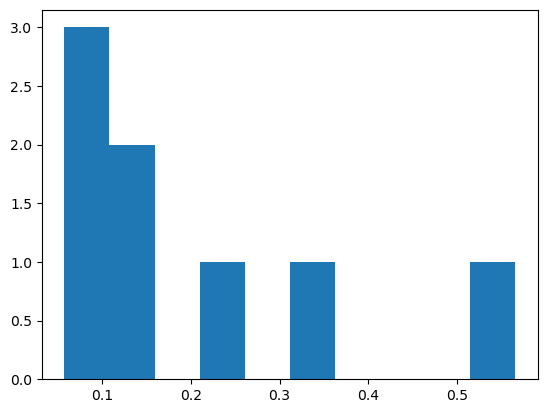

P-value = 0.0498718234
The null hypothesis can be rejected. The sample is NOT normally distributed.


In [14]:
# Check normality of the ASC group
norm_asc = check_norm(fd_data_asc)

In [8]:
# Check for equality of variances
def calc_var_equal(d1, d2):
    v1, v2 = np.var(d1), np.var(d2)
    if (v1 / v2) or (v2 / v1) >= 4:
        return False
    else:
        return True

In [15]:
var_equal = calc_var_equal(fd_data_td, fd_data_asc)

In [10]:
# Test for significant group differences
def test_sign_diff(d1, norm_d1, d2, norm_d2, var_equal):
    if norm_d1 == True and norm_d2 == True:
        if var_equal == True:
            print(stats.ttest_ind(a=d1, b=d2, equal_var=True))
        # https://www.statology.org/determine-equal-or-unequal-variance/
        else:
            print(stats.ttest_ind(a=d1, b=d2, equal_var=False))
    else:
        #https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.mannwhitneyu.html
        u, prob = stats.mannwhitneyu(d1, d2)
        print("u = {:g}".format(u))
        print("prob = {:g}".format(prob))
        # to get two-sided p-value:
        two_sided_prob = 2 * prob
        print("P-value = " + str(two_sided_prob))

In [16]:
test_sign_diff(fd_data_td, norm_td, fd_data_asc, norm_asc, var_equal)

u = 25
prob = 0.321267
P-value = 0.6425339366515838


# Create a function to unite the functions above, which would take factor as input, i.e. age, IQ and FD....


In [16]:
# age
df_age_all = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/ARB_cov_split.xlsx', sheet_name='age_asc_td_p', engine='openpyxl')
df_age_td = df_age_all.iloc[:9,1]
print(df_age_td)
df_age_asc = df_age_all.iloc[11:19,1]
print(df_age_asc)

0    23.0
1    20.0
2    23.0
3    36.0
4    22.0
5    24.0
6    37.0
7    28.0
8    51.0
Name: Age, dtype: float64
11    40.0
12    33.0
13    19.0
14    33.0
15    30.0
16    43.0
17    25.0
18    49.0
Name: Age, dtype: float64


In [17]:
# check normality of the TD group
k2, p = stats.normaltest(df_age_td)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

p = 0.0826605
The null hypothesis cannot be rejected


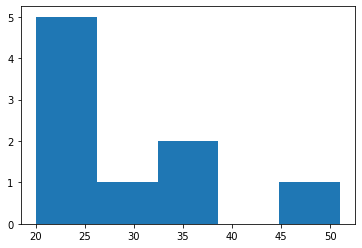

In [40]:
#visualise as well
plt.hist(df_age_td
         , bins = 5
        )
plt.show()

In [19]:
# check normality of the TD group
k2, p = stats.normaltest(df_age_asc)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

p = 0.977129
The null hypothesis cannot be rejected


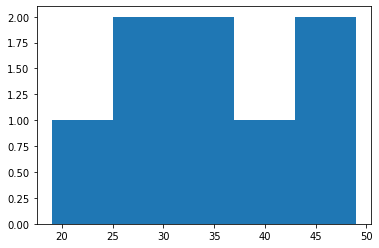

In [41]:
#visualise as well
plt.hist(df_age_asc
         , bins = 5
        )
plt.show()

In [21]:
#find variance for each group
print(np.var(df_age_td), np.var(df_age_asc))

91.55555555555556 83.25


In [22]:
# perform a two-sample t-test on the age data
stats.ttest_ind(a=df_age_td, b=df_age_asc, equal_var=True)

Ttest_indResult(statistic=-0.9636094797023772, pvalue=0.35052042689913065)

In [23]:
# IQ
df_iq_all = pd.read_excel(r'/Users/mishodimitrov/Downloads/PhD/Analysis/Project_Uno/ARB_cov_split.xlsx', sheet_name='iq_asc_td_p', engine='openpyxl')
df_iq_td = df_iq_all.iloc[:9,1]
print(df_iq_td)
df_iq_asc = df_iq_all.iloc[11:19,1] # N.B. there is a couple of missing value at the beginning of the ASC group
print(df_iq_asc)

0    119.0
1    117.0
2    123.0
3    121.0
4    114.0
5    128.0
6    115.0
7    114.0
8    107.0
Name: IQ, dtype: float64
11      NaN
12      NaN
13    118.0
14    125.0
15    107.0
16    106.0
17    118.0
18    128.0
Name: IQ, dtype: float64


In [24]:
# Interpolated missing values

iq_td_mean = df_iq_td.mean()
df_iq_td = df_iq_td.fillna(iq_td_mean)
print(df_iq_td)

iq_asc_mean = df_iq_asc.mean()
df_iq_asc = df_iq_asc.fillna(iq_asc_mean)
print(df_iq_asc)

0    119.0
1    117.0
2    123.0
3    121.0
4    114.0
5    128.0
6    115.0
7    114.0
8    107.0
Name: IQ, dtype: float64
11    117.0
12    117.0
13    118.0
14    125.0
15    107.0
16    106.0
17    118.0
18    128.0
Name: IQ, dtype: float64


In [25]:
# check normality of the TD group
k2, p = stats.normaltest(df_iq_td)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

p = 0.877296
The null hypothesis cannot be rejected


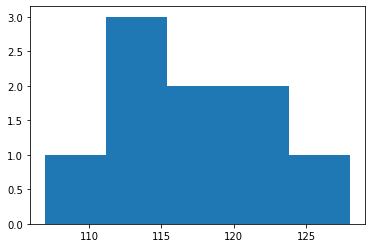

In [42]:
#visualise as well
plt.hist(df_iq_td
         , bins = 5
        )
plt.show()

In [27]:
# check normality of the TD group
k2, p = stats.normaltest(df_iq_asc)

alpha = 1e-3

print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution

    print("The null hypothesis can be rejected")

else:

    print("The null hypothesis cannot be rejected")

p = 0.938027
The null hypothesis cannot be rejected


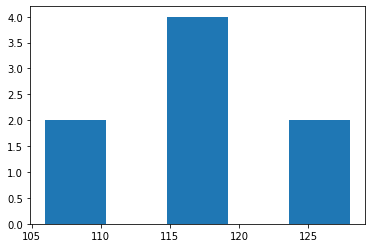

In [43]:
#visualise as well
plt.hist(df_iq_asc
         , bins = 5
        )
plt.show()

In [30]:
#find variance for each group
print(np.var(df_iq_td), np.var(df_iq_asc))

32.91358024691358 51.0


In [31]:
# perform a two-sample t-test on the age data
stats.ttest_ind(a=df_iq_td, b=df_iq_asc, equal_var=True)

Ttest_indResult(statistic=0.1668630007003614, pvalue=0.8697064477738561)

In [2]:
pipeline_list = []
for n in range(12):
        # get a pipeline
        pipeline = pd.read_excel(r'~/Downloads/PhD/Analysis/QC/ARB_QC.xlsx', sheet_name=n)
        stacked_pipeline = pipeline.stack()
        pipeline_list.append(stacked_pipeline)

In [3]:
pipeline_list[1]

0    0       3.26922
     0.1     3.03093
     0.2     3.06855
     0.3     3.82601
     0.4     3.34560
              ...   
190  0.12    2.51645
     0.13    8.52097
     0.14    4.05079
     0.15    2.90582
     0.16    4.78742
Length: 3247, dtype: float64

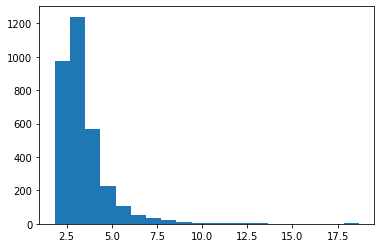

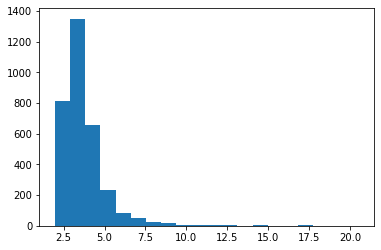

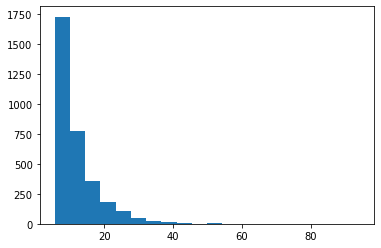

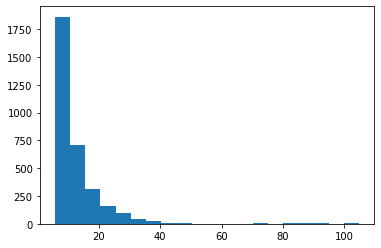

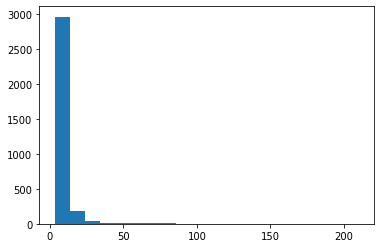

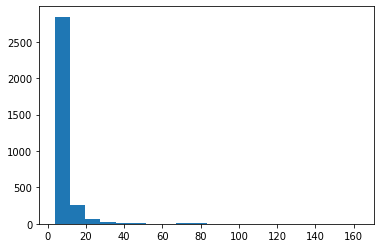

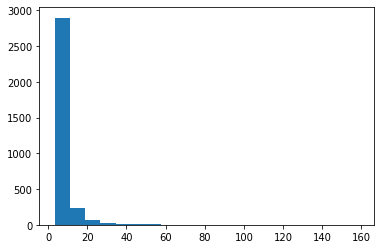

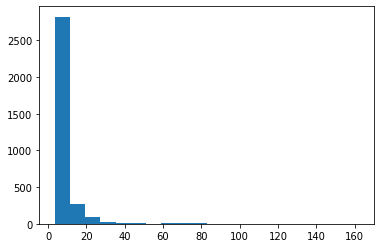

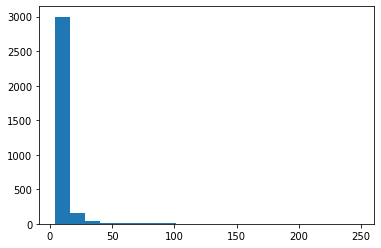

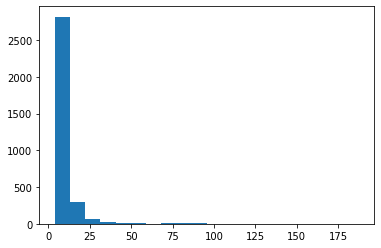

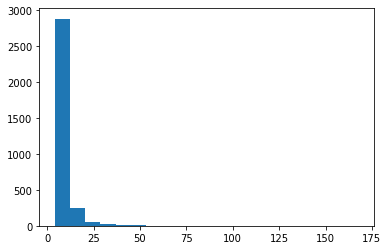

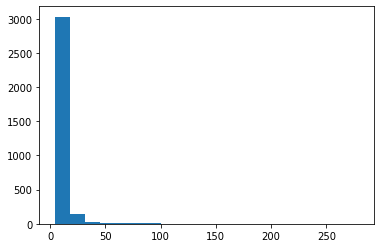

In [62]:
# check normality
for n in range(12):
    plt.hist(pipeline_list[n], bins = 20)
    plt.show()

In [4]:
xls = xlrd.open_workbook(r'~/Downloads/PhD/Analysis/QC/ARB_QC.xlsx', on_demand=True)
pipeline_names = xls.sheet_names()
pipeline_names

['MEICA_3_echo',
 'MEICA_4_echo',
 '1_echo',
 '1_echo_SDC',
 '3_echo',
 '3_echo_SDC',
 '3_echo_T2s',
 '3_echo_T2s_SDC',
 '4_echo',
 '4_echo_SDC',
 '4_echo_T2s',
 '4_echo_T2s_SDC']

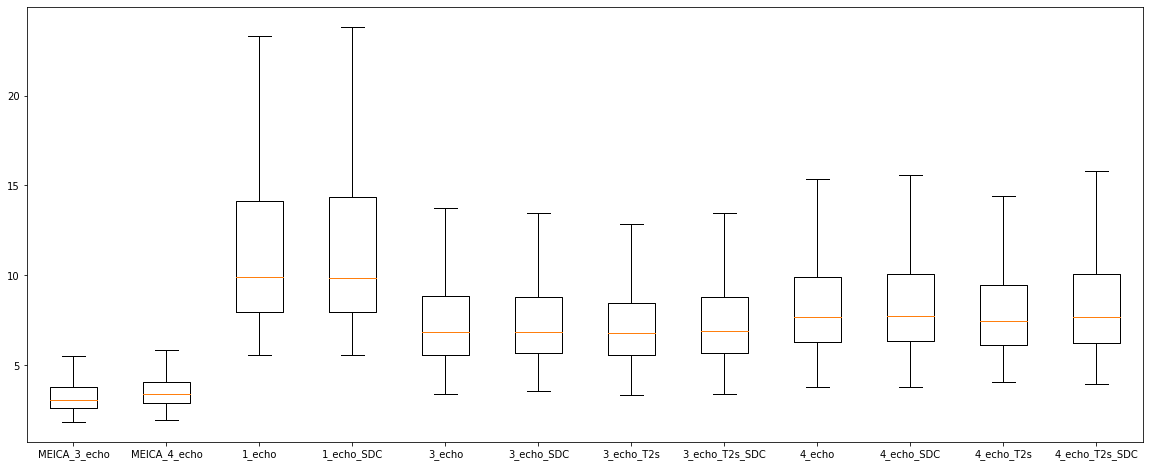

In [5]:
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html

fig, ax = plt.subplots(figsize=(20,8))
dvars_figure = ax.boxplot(pipeline_list, 
                          #notch=True, 
                          bootstrap=5000, 
                          showfliers=False)
ax.set_xticklabels(pipeline_names)
#plt.show(dvars_figure)
plt.savefig("dvars.png")

In [9]:
# get the median value
# the integer should match the pipeline of interest, i.e. ranges from 0 to 11 in this case
#print(dvars_figure['medians'][0].get_ydata())
# for the lower and upper bounds, each pipeline gets a couple of indices, i.e. 
# pipeline 1 has 0 for lower and 1 for upper boundary, pipeline 2 has 2 for lower and 3 for upper boundary etc.
# get the lower bound of the whiskers
#print(dvars_figure['caps'][0].get_ydata())
# get the upper bound of the whiskers
#print(dvars_figure['caps'][1].get_ydata())

In [5]:
# convert the list of Pandas Series objects into a Pandas DataFrame object
df_pipeline_list = pd.concat(pipeline_list, axis=1)
df_pipeline_list

0        1         2        3         4         5         6   \
0   0     3.27061  3.26922   8.18908  18.8007  13.47820  13.50270   6.00060   
    0.1   2.49046  3.03093  16.61550  23.5093  15.49000  15.08640   7.03698   
    0.2   2.86700  3.06855   8.22911  18.3823  18.26410  14.66840   5.59414   
    0.3   3.61683  3.82601  21.77850  59.0945  39.43180  20.57370   7.03026   
    0.4   3.20922  3.34560   7.13750  28.3236  22.87900  22.83500   5.25222   
...           ...      ...       ...      ...       ...       ...       ...   
190 0.12  2.25133  2.51645  13.40020  13.5402   4.00597   4.24402   4.30930   
    0.13  6.74825  8.52097  30.42650  23.9909  37.70760  39.05880  36.09080   
    0.14  4.51715  4.05079  11.31030  10.8822   8.96405   8.91679   8.69740   
    0.15  2.60696  2.90582  12.27250  12.8591   6.04500   6.25096   5.71284   
    0.16  6.46680  4.78742  14.16430  13.3600   9.57494   9.99594  12.14570   

                7         8         9         10        11  
0   0     13.45690  15.21930  18.77520   7.00165  14.90970  
    0.1   20.37080  16.47880  16.17540   7.60036  15.99170  
    0.2   16.87830  20.17850  14.32950   6.85083  21.28800  
    0.3   24.74810  23.14750  22.90680   8.91669  23.32580  
    0.4   22.97470  25.36830  25.21820   6.15223  29.73170  
...            ...       ...       ...       ...       ...  
190 0.12   4.63428   4.67924   4.57106   4.74442   4.79032  
    0.13  38.46600  42.46290  42.57440  40.55970  44.96210  
    0.14   8.90285  10.48090   9.88066   9.61186  10.70270  
    0.15   6.38231   6.56449   7.04411   6.35265   6.57341  
    0.16  12.77400  13.78880  14.16370  13.03640  13.29500  

[3247 rows x 12 columns]

In [6]:
# Rename columns so that they are labelled by the pipeline names
new_pipeline_names = ['3-echo ME-ICA', 
 '4-echo ME-ICA',
 '1-echo baseline',
 '1-echo + SDC',
 '3-echo',
 '3-echo + SDC',
 '3-echo + T2s',
 '3-echo + T2s + SDC',
 '4-echo',
 '4-echo + SDC',
 '4-echo + T2s',
 '4-echo + T2s + SDC']
df_pipeline_list.columns = new_pipeline_names

In [7]:
# visualise the updated dataframe
df_pipeline_list

3-echo ME-ICA  4-echo ME-ICA  1-echo baseline  1-echo + SDC  \
0   0           3.27061        3.26922          8.18908       18.8007   
    0.1         2.49046        3.03093         16.61550       23.5093   
    0.2         2.86700        3.06855          8.22911       18.3823   
    0.3         3.61683        3.82601         21.77850       59.0945   
    0.4         3.20922        3.34560          7.13750       28.3236   
...                 ...            ...              ...           ...   
190 0.12        2.25133        2.51645         13.40020       13.5402   
    0.13        6.74825        8.52097         30.42650       23.9909   
    0.14        4.51715        4.05079         11.31030       10.8822   
    0.15        2.60696        2.90582         12.27250       12.8591   
    0.16        6.46680        4.78742         14.16430       13.3600   

            3-echo  3-echo + SDC  3-echo + T2s  3-echo + T2s + SDC    4-echo  \
0   0     13.47820      13.50270       6.00060            13.45690  15.21930   
    0.1   15.49000      15.08640       7.03698            20.37080  16.47880   
    0.2   18.26410      14.66840       5.59414            16.87830  20.17850   
    0.3   39.43180      20.57370       7.03026            24.74810  23.14750   
    0.4   22.87900      22.83500       5.25222            22.97470  25.36830   
...            ...           ...           ...                 ...       ...   
190 0.12   4.00597       4.24402       4.30930             4.63428   4.67924   
    0.13  37.70760      39.05880      36.09080            38.46600  42.46290   
    0.14   8.96405       8.91679       8.69740             8.90285  10.48090   
    0.15   6.04500       6.25096       5.71284             6.38231   6.56449   
    0.16   9.57494       9.99594      12.14570            12.77400  13.78880   

          4-echo + SDC  4-echo + T2s  4-echo + T2s + SDC  
0   0         18.77520       7.00165            14.90970  
    0.1       16.17540       7.60036            15.99170  
    0.2       14.32950       6.85083            21.28800  
    0.3       22.90680       8.91669            23.32580  
    0.4       25.21820       6.15223            29.73170  
...                ...           ...                 ...  
190 0.12       4.57106       4.74442             4.79032  
    0.13      42.57440      40.55970            44.96210  
    0.14       9.88066       9.61186            10.70270  
    0.15       7.04411       6.35265             6.57341  
    0.16      14.16370      13.03640            13.29500  

[3247 rows x 12 columns]

In [8]:
df_pipeline_list.iloc[:,0]

0    0       3.27061
     0.1     2.49046
     0.2     2.86700
     0.3     3.61683
     0.4     3.20922
              ...   
190  0.12    2.25133
     0.13    6.74825
     0.14    4.51715
     0.15    2.60696
     0.16    6.46680
Name: 3-echo ME-ICA, Length: 3247, dtype: float64

In [9]:
for i in range(df_pipeline_list.shape[1]):
    print('The median for ' + df_pipeline_list.columns[i] + ' is = ' + str(np.median(df_pipeline_list.iloc[:,i])) )

The median for 3-echo ME-ICA is = 3.06789
The median for 4-echo ME-ICA is = 3.39795
The median for 1-echo baseline is = 9.72028
The median for 1-echo + SDC is = 9.61166
The median for 3-echo is = 6.8628
The median for 3-echo + SDC is = 6.95338
The median for 3-echo + T2s is = 6.83042
The median for 3-echo + T2s + SDC is = 6.9607
The median for 4-echo is = 7.75452
The median for 4-echo + SDC is = 7.81463
The median for 4-echo + T2s is = 7.51995
The median for 4-echo + T2s + SDC is = 7.83426


In [10]:
# create a list that contains all possible pairs of pipelines WITHOUT repetitions!!
combo_list = list(itertools.combinations(pipeline_names, 2))
print(combo_list)
# to see how many comparisons would be made
print(len(combo_list))

[('MEICA_3_echo', 'MEICA_4_echo'), ('MEICA_3_echo', '1_echo'), ('MEICA_3_echo', '1_echo_SDC'), ('MEICA_3_echo', '3_echo'), ('MEICA_3_echo', '3_echo_SDC'), ('MEICA_3_echo', '3_echo_T2s'), ('MEICA_3_echo', '3_echo_T2s_SDC'), ('MEICA_3_echo', '4_echo'), ('MEICA_3_echo', '4_echo_SDC'), ('MEICA_3_echo', '4_echo_T2s'), ('MEICA_3_echo', '4_echo_T2s_SDC'), ('MEICA_4_echo', '1_echo'), ('MEICA_4_echo', '1_echo_SDC'), ('MEICA_4_echo', '3_echo'), ('MEICA_4_echo', '3_echo_SDC'), ('MEICA_4_echo', '3_echo_T2s'), ('MEICA_4_echo', '3_echo_T2s_SDC'), ('MEICA_4_echo', '4_echo'), ('MEICA_4_echo', '4_echo_SDC'), ('MEICA_4_echo', '4_echo_T2s'), ('MEICA_4_echo', '4_echo_T2s_SDC'), ('1_echo', '1_echo_SDC'), ('1_echo', '3_echo'), ('1_echo', '3_echo_SDC'), ('1_echo', '3_echo_T2s'), ('1_echo', '3_echo_T2s_SDC'), ('1_echo', '4_echo'), ('1_echo', '4_echo_SDC'), ('1_echo', '4_echo_T2s'), ('1_echo', '4_echo_T2s_SDC'), ('1_echo_SDC', '3_echo'), ('1_echo_SDC', '3_echo_SDC'), ('1_echo_SDC', '3_echo_T2s'), ('1_echo_SDC'

In [14]:
# multiple comparisons correction
# Bonferroni is not appropriate (and too stringent) as the samples are not independent !!!
# Perhaps calculate p-values and correct using scipy.stats and module below 
# and then use those 'custom' corrected p-values for statannot
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html

In [15]:
# Copy from the mFD-FC script!!!!!

In [52]:


# create the boxplot using seaborn instead of matplotlib
#sb_ax = sns.boxplot(data=pipeline_list, showfliers=False)

# plot it after a Wilcoxon test for significance 
#test_results = add_stat_annotation(sb_ax, data=df_pipeline_list,
#                                   box_pairs=[combo_list[n] for n in range(len(combo_list))],
#                                   test='Wilcoxon', text_format='star',
#                                   loc='inside', verbose=2)
#test_results

In [11]:
uncorrected_p_vals = []
for n in range(len(combo_list)):
    combo_cont1 = combo_list[n][0]
    combo_cont2 = combo_list[n][1]
    w, p = wilcoxon(df_pipeline_list.loc[:, combo_cont1], df_pipeline_list.loc[:, combo_cont2])
    uncorrected_p_vals.append(p)
uncorrected_p_vals

KeyError: 'MEICA_3_echo'

In [12]:
# Correct the p-values using the FDR method
# and more specifically, one of the newer variations (https://www.jstor.org/stable/20441303?seq=1)
corrected_p_vals_extra = multipletests(uncorrected_p_vals, alpha=0.05, method='fdr_tsbky')
corrected_p_vals_extra

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]),
 array([2.36514237e-242, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 6.30344994e-003, 0.00000000e+000, 0.00000000e+000,
        0.000000

In [13]:
corrected_p_vals = corrected_p_vals_extra[1]
corrected_p_vals

array([2.36514237e-242, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 6.30344994e-003, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 4.97139610e-311, 7.40616940e-304,
       0.00000000e+000, 3.75164701e-288, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 2.75806304e-008, 1.66863211e-038,
       4.75984259e-009, 0.00000000e+000, 0.00000000e+000, 1.35944061e-283,
       0.00000000e+000, 1.16684266e-054, 1.67768065e-003, 0.00000000e+000,
       0.00000000e+000, 1.05013416e-253, 0.00000000e+000, 5.44500853e-058,
       0.00000000e+000, 0

In [14]:
print("Values bigger than 0.05 =", corrected_p_vals[corrected_p_vals < 0.01])

Values bigger than 0.05 = [2.36514237e-242 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 6.30344994e-003 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 4.97139610e-311 7.40616940e-304
 0.00000000e+000 3.75164701e-288 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 2.75806304e-008 1.66863211e-038
 4.75984259e-009 0.00000000e+000 0.00000000e+000 1.35944061e-283
 0.00000000e+000 1.16684266e-054 1.67768065e-003 0.00000000e+000
 0.00000000e+000 1.05013416e-253 0.00000000e+000 5.44500853e-058
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 5.38535826e-262 0.00000000e+000

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


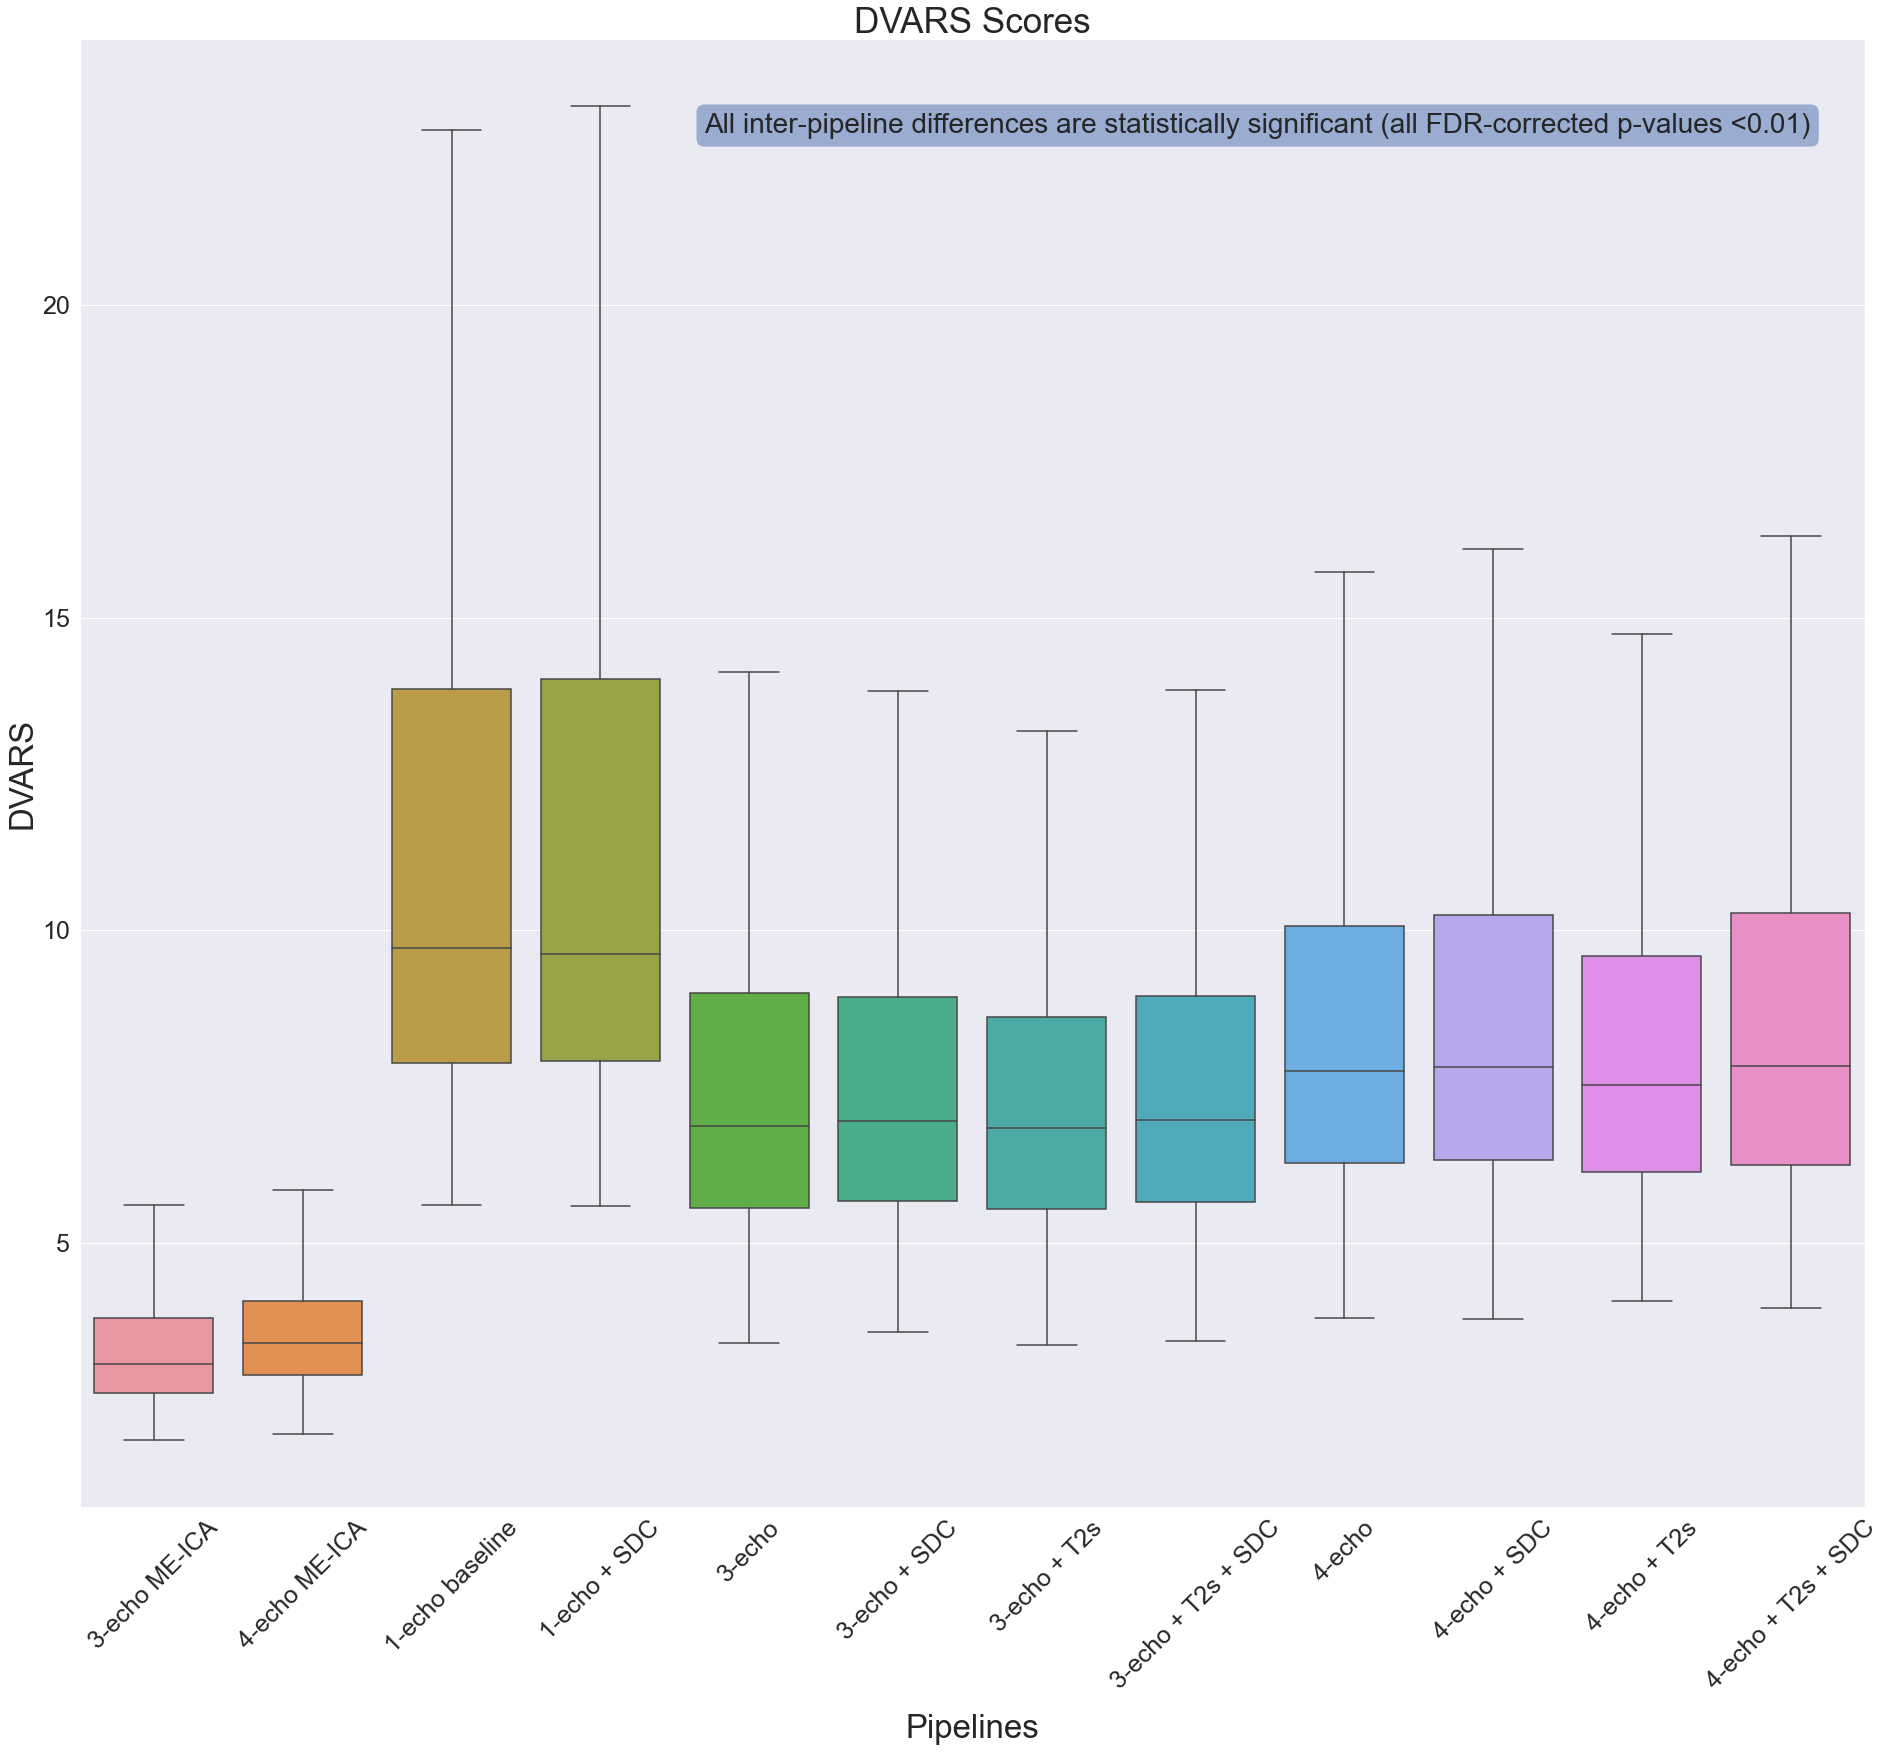

In [42]:
plt.rcParams["axes.labelsize"] = 33

# create the boxplot using seaborn instead of matplotlib
fig, ax = plt.subplots(figsize=(32,27))
sns.set(font_scale = 2)
ax.tick_params(axis='both', which='both', labelsize=15)
ax.set_xticklabels(new_pipeline_names, rotation=45, fontsize=25)
ax.set_yticklabels(['0', '5', '10', '15', '20'], rotation=0, fontsize=25)
ax.xaxis.labelpad = 20

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', 
             #facecolor='wheat', 
             alpha=0.5)

# place a text box in upper right in axes coords
textstr = 'All inter-pipeline differences are statistically significant (all FDR-corrected p-values <0.01)'
ax.text(0.35, 0.95, textstr, transform=ax.transAxes, fontsize=28,
        verticalalignment='top', bbox=props)

sb_ax = sns.boxplot(data=df_pipeline_list, #corr_matrix_list, 
                    order=new_pipeline_names, 
                    showfliers=False).set(
    xlabel='Pipelines', 
    ylabel='DVARS'
)


# plot with corrected p-values 

# CHANGE THIS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#test_results = add_stat_annotation(sb_ax, data=df_pipeline_list, order=pipeline_names,
#                                   box_pairs=[combo_list[n] for n in range(len(combo_list))],
#                                   perform_stat_test=False, pvalues=corrected_p_vals,
#                                   text_format='star',
#                                   loc='outside', verbose=2)

#plt.title('DVARS Scores')
ax.set_title('DVARS Scores',fontsize= 35) # title of plot

#plt.show()
plt.savefig("DVARS.png")